Paso 1: Importaciones y configuración

In [1]:
import os
import glob
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from rasterio.plot import show
import fiona, time

# Configuración de rutas relativas (asumiendo que el notebook está en /notebooks)
RAW_DIR = "../data/raw"
FIGURE_DIR = "../outputs/figures"

print("✅ Librerías importadas y rutas configuradas.")

✅ Librerías importadas y rutas configuradas.


Exploración de rasters (viento, vegetación, altura)

In [4]:
# Diccionario con tus archivos raster clave
rasters = {
    "Viento (ERA5)": os.path.join(RAW_DIR, "era5_wind_valdivia.tif"),
    "Vegetación (Sentinel-2)": os.path.join(RAW_DIR, "sentinel2_valdivia.tif"),
    "Topología (SRTM)": os.path.join(RAW_DIR, "srtm_valdivia.tif") # Corregí strm a srtm
}

print("--- METADATA DE RASTERS ---")
for nombre, ruta in rasters.items():
    if os.path.exists(ruta):
        with rasterio.open(ruta) as src:
            print(f"📂 {nombre}:")
            print(f"   - Sistema de Coordenadas (CRS): {src.crs}")
            print(f"   - Tamaño: {src.width}x{src.height} píxeles")
            print(f"   - Bandas: {src.count}")
            print(f"   - Tipo de dato: {src.dtypes[0]}")
            print("-" * 30)
    else:
        print(f"❌ NO ENCONTRADO: {nombre} en {ruta}")

--- METADATA DE RASTERS ---
📂 Viento (ERA5):
   - Sistema de Coordenadas (CRS): EPSG:4326
   - Tamaño: 16x16 píxeles
   - Bandas: 2
   - Tipo de dato: float64
------------------------------
📂 Vegetación (Sentinel-2):
   - Sistema de Coordenadas (CRS): EPSG:32718
   - Tamaño: 1228x1467 píxeles
   - Bandas: 4
   - Tipo de dato: uint16
------------------------------
📂 Topología (SRTM):
   - Sistema de Coordenadas (CRS): EPSG:4326
   - Tamaño: 521x484 píxeles
   - Bandas: 1
   - Tipo de dato: int16
------------------------------



Diagnóstico de cobertura:
   Total píxeles      : 256
   Píxeles válidos    : 256
   Píxeles sin datos  : 0
   % sin datos        : 0.00%
   % cobertura útil   : 100.00%

Estadísticas para Viento (ERA5):

 Banda U
   min: 0.296
   max: 1.263
   mean: 0.636
   std: 0.271
   p5: 0.296
   p50: 0.502
   p95: 1.010


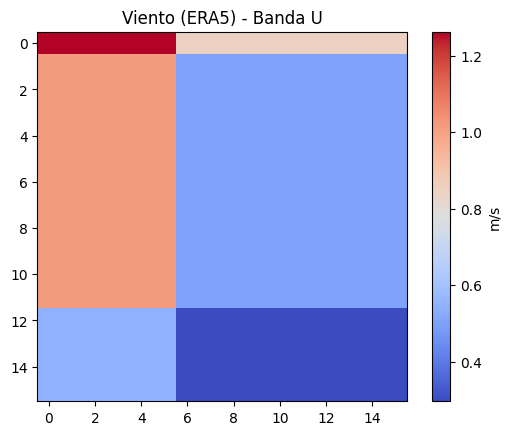


 Banda V
   min: 1.945
   max: 2.553
   mean: 2.090
   std: 0.186
   p5: 1.945
   p50: 1.961
   p95: 2.360


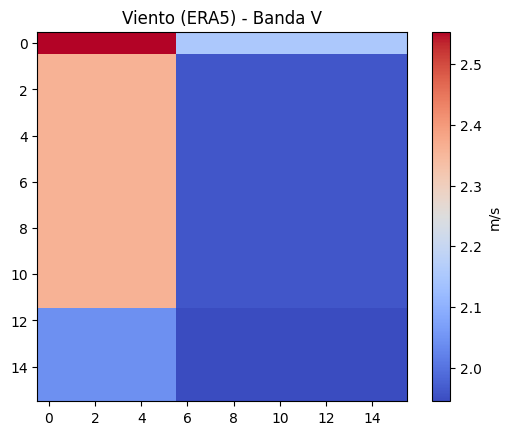


Magnitud del viento
   min: 1.967
   max: 2.848
   mean: 2.194
   std: 0.260
   p5: 1.967
   p50: 2.024
   p95: 2.567


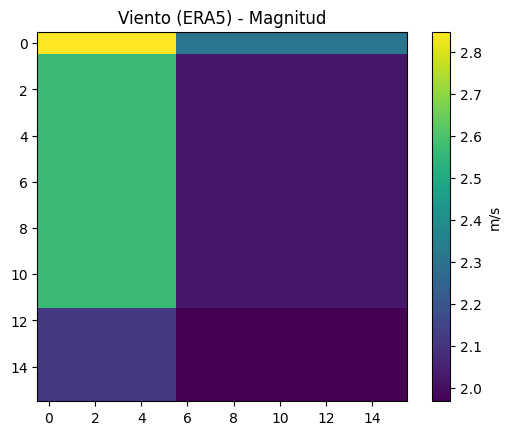


Dirección del viento


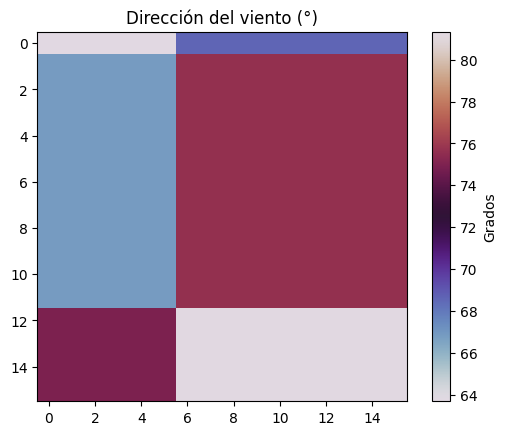


Diagnóstico de cobertura:
   Total píxeles      : 1,801,476
   Píxeles válidos    : 1,801,476
   Píxeles sin datos  : 0
   % sin datos        : 0.00%
   % cobertura útil   : 100.00%

Estadísticas para Vegetación (Sentinel-2):


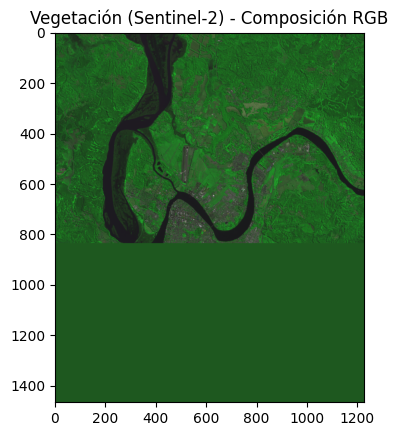


NDVI
   min: -0.504
   max: 0.424
   mean: -0.037
   std: 0.039
   p5: -0.128
   p50: -0.025
   p95: -0.005


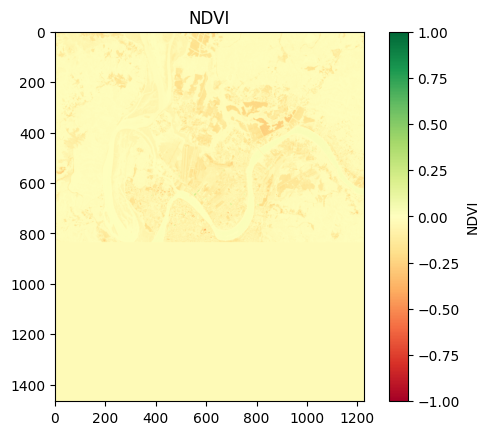

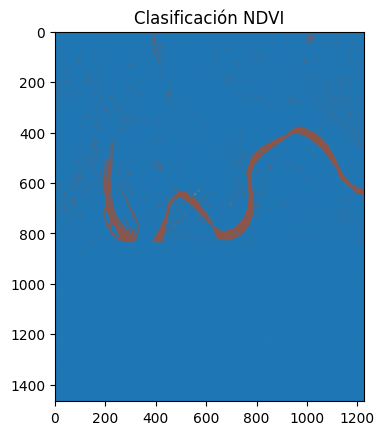


Diagnóstico de cobertura:
   Total píxeles      : 252,164
   Píxeles válidos    : 234,637
   Píxeles sin datos  : 17,527
   % sin datos        : 6.95%
   % cobertura útil   : 93.05%

Estadísticas para Topología (SRTM):

Elevación
   min: -21.00
   max: 343.00
   mean: 52.27
   std: 74.10
   p5: 0.00
   p50: 15.00
   p95: 229.00


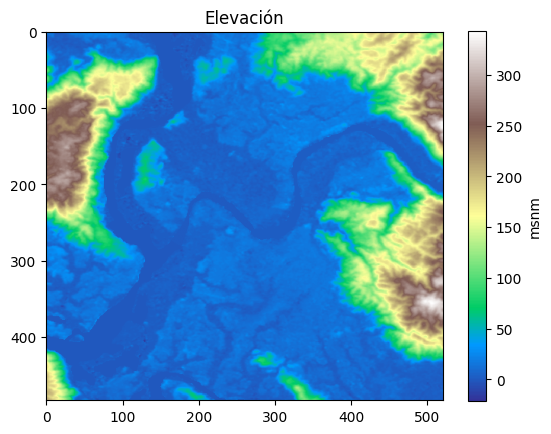


Pendiente


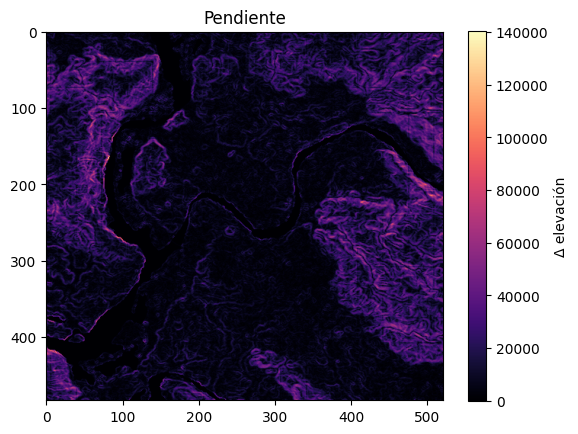

Figuras guardadas en: ../outputs/figures/raster


In [7]:
RASTER_DIR = "../outputs/figures/raster"
os.makedirs(RASTER_DIR, exist_ok=True)

# Método para obtener estadística de los pixeles del raster
def diagnostico_cobertura(data, nodata_value=0):
    """
    Estima porcentaje de píxeles inválidos (sin datos reales).
    Considera nodata cuando todas las bandas son nodata_value.
    """
    # Para raster multibanda: nodata si TODAS las bandas son nodata
    if data.ndim == 3:
        mask_nodata = np.all(data == nodata_value, axis=0)
    else:
        mask_nodata = data == nodata_value

    total_pix = mask_nodata.size
    nodata_pix = np.sum(mask_nodata)
    valid_pix = total_pix - nodata_pix
    porcentaje = (nodata_pix / total_pix) * 100

    return {
        "total_pixeles": total_pix,
        "pixeles_validos": valid_pix,
        "pixeles_nodata": nodata_pix,
        "porcentaje_nodata": porcentaje,
        "porcentaje_cobertura": 100 - porcentaje
    }

# Método para obtener estadísticas del raster
def estadisticas_basicas(arr):
    """Calcula estadísticas clásicas ignorando NaN."""
    arr = arr[np.isfinite(arr)]
    return {
        "min": np.min(arr),
        "max": np.max(arr),
        "mean": np.mean(arr),
        "std": np.std(arr),
        "p5": np.percentile(arr, 5),
        "p50": np.percentile(arr, 50),
        "p95": np.percentile(arr, 95)
    }

# Método para imprimir un histograma de los raster
def plot_histograma(arr, titulo, fname):
    """Grafica histograma de una banda."""
    arr = arr[np.isfinite(arr)]
    plt.figure()
    plt.hist(arr, bins=50)
    plt.title(titulo)
    plt.xlabel("Valor")
    plt.ylabel("Frecuencia")
    plt.savefig(os.path.join(RASTER_DIR, fname), dpi=300, bbox_inches="tight")
    plt.close()

os.makedirs(RASTER_DIR, exist_ok=True)

for nombre, ruta in rasters.items():
    if os.path.exists(ruta):
        with rasterio.open(ruta) as src:
            data = src.read()

            # Evaluar los pixeles de data
            diag = diagnostico_cobertura(data)

            print("\nDiagnóstico de cobertura:")
            print(f"   Total píxeles      : {diag['total_pixeles']:,}")
            print(f"   Píxeles válidos    : {diag['pixeles_validos']:,}")
            print(f"   Píxeles sin datos  : {diag['pixeles_nodata']:,}")
            print(f"   % sin datos        : {diag['porcentaje_nodata']:.2f}%")
            print(f"   % cobertura útil   : {diag['porcentaje_cobertura']:.2f}%")

            print(f"\nEstadísticas para {nombre}:")
            
            # ERA5 VIENTO
            if "Viento" in nombre:
                u, v = data

                for i, band in enumerate([u, v]):
                    eje = "U" if i == 0 else "V"

                    print(f"\n Banda {eje}")
                    stats = estadisticas_basicas(band)
                    for k, val in stats.items():
                        print(f"   {k}: {val:.3f}")

                    # Mapa banda
                    plt.imshow(band, cmap="coolwarm")
                    plt.title(f"{nombre} - Banda {eje}")
                    plt.colorbar(label="m/s")
                    fname = f"{nombre.replace(' ', '_').lower()}_{eje}.png"
                    plt.savefig(os.path.join(RASTER_DIR, fname), dpi=300, bbox_inches="tight")
                    plt.show()

                    # Histograma
                    plot_histograma(
                        band,
                        f"Histograma viento banda {eje}",
                        f"hist_viento_{eje}.png",
                    )

                # Magnitud
                mag = np.sqrt(u**2 + v**2)

                print("\nMagnitud del viento")
                stats = estadisticas_basicas(mag)
                for k, val in stats.items():
                    print(f"   {k}: {val:.3f}")

                plt.imshow(mag, cmap="viridis")
                plt.title(f"{nombre} - Magnitud")
                plt.colorbar(label="m/s")
                plt.savefig(os.path.join(RASTER_DIR, "viento_magnitud.png"), dpi=300)
                plt.show()

                plot_histograma(
                    mag,
                    "Histograma magnitud del viento",
                    "hist_viento_magnitud.png",
                )

                # Dirección 
                direc = np.arctan2(v, u) * 180 / np.pi
                direc = (direc + 360) % 360

                print("\nDirección del viento")
                plt.imshow(direc, cmap="twilight")
                plt.title("Dirección del viento (°)")
                plt.colorbar(label="Grados")
                plt.savefig(os.path.join(RASTER_DIR, "viento_direccion.png"), dpi=300)
                plt.show()

            # SENTINEL-2 VEGETACIÓN
            elif "Vegetación" in nombre:

                # RGB
                rgb = np.dstack([data[0], data[1], data[2]])

                plt.imshow(rgb / np.max(rgb))
                plt.title(f"{nombre} - Composición RGB")
                plt.savefig(os.path.join(RASTER_DIR, "sentinel_rgb.png"), dpi=300)
                plt.show()

                # NDVI 
                red = data[0].astype(float)
                nir = data[3].astype(float)

                ndvi = (nir - red) / (nir + red + 1e-6)

                print("\nNDVI")
                stats = estadisticas_basicas(ndvi)
                for k, val in stats.items():
                    print(f"   {k}: {val:.3f}")

                plt.imshow(ndvi, cmap="RdYlGn", vmin=-1, vmax=1)
                plt.title("NDVI")
                plt.colorbar(label="NDVI")
                plt.savefig(os.path.join(RASTER_DIR, "ndvi.png"), dpi=300)
                plt.show()

                plot_histograma(ndvi, "Histograma NDVI", "hist_ndvi.png")

                # ----- Clasificación NDVI -----
                clases = np.zeros_like(ndvi)
                clases[ndvi < 0] = 0
                clases[(ndvi >= 0) & (ndvi < 0.2)] = 1
                clases[(ndvi >= 0.2) & (ndvi < 0.5)] = 2
                clases[ndvi >= 0.5] = 3

                plt.imshow(clases, cmap="tab10")
                plt.title("Clasificación NDVI")
                plt.savefig(os.path.join(RASTER_DIR, "clases_ndvi.png"), dpi=300)
                plt.show()

            # SRTM TOPOGRAFÍA
            elif "Topología" in nombre:

                elev = data[0]

                print("\nElevación")
                stats = estadisticas_basicas(elev)
                for k, val in stats.items():
                    print(f"   {k}: {val:.2f}")

                plt.imshow(elev, cmap="terrain")
                plt.title("Elevación")
                plt.colorbar(label="msnm")
                plt.savefig(os.path.join(RASTER_DIR, "elevacion.png"), dpi=300)
                plt.show()

                plot_histograma(
                    elev,
                    "Histograma elevación",
                    "hist_elevacion.png"
                )

                # Pendiente
                dy, dx = np.gradient(elev, src.res[1], src.res[0])
                slope = np.sqrt(dx**2 + dy**2)

                print("\nPendiente")
                plt.imshow(slope, cmap="magma")
                plt.title("Pendiente")
                plt.colorbar(label="Δ elevación")
                plt.savefig(os.path.join(RASTER_DIR, "pendiente.png"), dpi=300)
                plt.show()
    
print(f"Figuras guardadas en: {RASTER_DIR}")

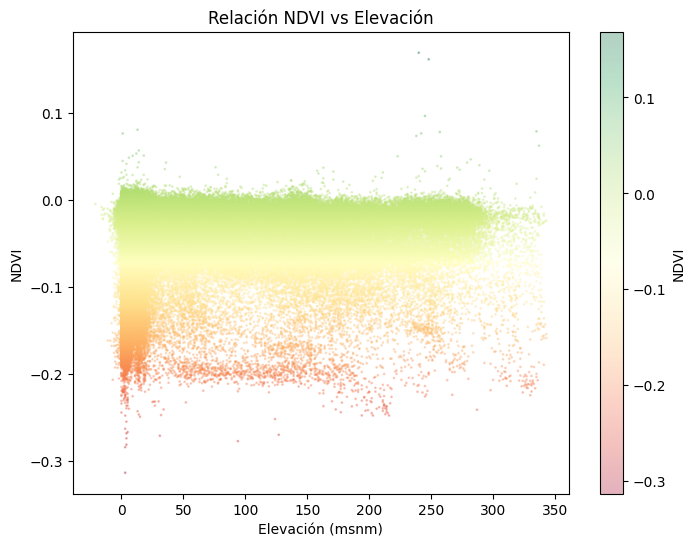

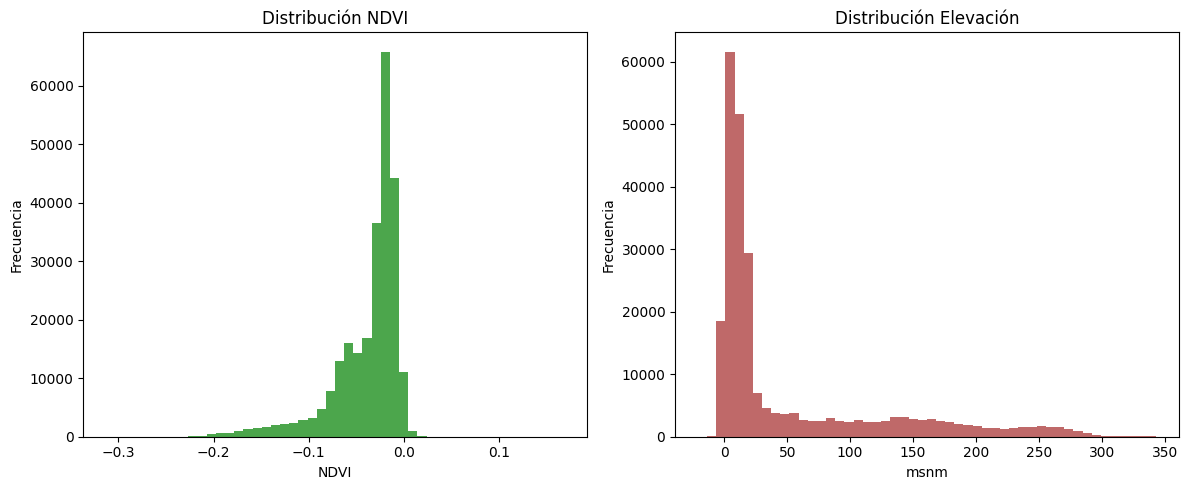

In [6]:
# --- NDVI (Sentinel-2) ---
with rasterio.open(rasters["Vegetación (Sentinel-2)"]) as src:
    data = src.read()
    nir = data[3].astype(float)
    red = data[0].astype(float)
    ndvi = (nir - red) / (nir + red + 1e-6)

# --- Elevación (SRTM) ---
with rasterio.open(rasters["Topología (SRTM)"]) as src:
    elev = src.read(1).astype(float)

# --- Ajuste de dimensiones ---
min_shape = (min(ndvi.shape[0], elev.shape[0]), min(ndvi.shape[1], elev.shape[1]))
ndvi_crop = ndvi[:min_shape[0], :min_shape[1]]
elev_crop = elev[:min_shape[0], :min_shape[1]]

# Crear carpeta RASTER_DIR si no existe
os.makedirs(RASTER_DIR, exist_ok=True)

# --- Scatter plot NDVI vs Elevación ---
plt.figure(figsize=(8,6))
plt.scatter(elev_crop.flatten(), ndvi_crop.flatten(), s=1, alpha=0.3,
            c=ndvi_crop.flatten(), cmap="RdYlGn")
plt.xlabel("Elevación (msnm)")
plt.ylabel("NDVI")
plt.title("Relación NDVI vs Elevación")
plt.colorbar(label="NDVI")

# Guardar figura
scatter_path = os.path.join(RASTER_DIR, "ndvi_vs_elevacion_scatter.png")
plt.savefig(scatter_path, dpi=300, bbox_inches="tight")
plt.show()

# --- Histogramas comparativos ---
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(ndvi_crop.flatten(), bins=50, color="green", alpha=0.7)
plt.title("Distribución NDVI")
plt.xlabel("NDVI")
plt.ylabel("Frecuencia")

plt.subplot(1,2,2)
plt.hist(elev_crop.flatten(), bins=50, color="brown", alpha=0.7)
plt.title("Distribución Elevación")
plt.xlabel("msnm")
plt.ylabel("Frecuencia")

plt.tight_layout()

# Guardar figura
hist_path = os.path.join(RASTER_DIR, "ndvi_elevacion_histogramas.png")
plt.savefig(hist_path, dpi=300, bbox_inches="tight")
plt.show()


Exploración de CONAF (Amenaza y Riesgo)

In [ ]:
# Rutas a los shapefiles de CONAF
path_amenaza = os.path.join(RAW_DIR, "conaf_amenaza/shapefiles/14_amenaza_shape.shp")
path_riesgo = os.path.join(RAW_DIR, "conaf_riesgo/shapefiles/14_riesgo_shape.shp")

print("--- EXPLORACIÓN VECTORIAL CONAF ---")

if os.path.exists(path_amenaza):
    gdf_amenaza = gpd.read_file(path_amenaza)
    print(f"✅ Amenaza cargada. Filas: {len(gdf_amenaza)}")
    print("Columnas disponibles:", gdf_amenaza.columns.tolist())
    display(gdf_amenaza.head(3)) 
    
    # Visualización rápida del mapa
    ax = gdf_amenaza.plot(figsize=(8, 6))
    plt.title("Shapefile de Amenaza (Región completa)")
    plt.tight_layout()
    plt.savefig(os.path.join(SHAPEFILE_DIR, "amenaza_mapa.png"), dpi=300)
    plt.show()
else:
    print(f"❌ No se encontró el archivo de Amenaza: {path_amenaza}")


# --- ESTADÍSTICAS DE AMENAZA (CONAF) ---
if 'gridcode' in gdf_amenaza.columns:
    conteo_amenaza = gdf_amenaza['gridcode'].value_counts().sort_index()
    
    print("Distribución de niveles de amenaza (Polígonos):")
    print(conteo_amenaza)

    # Gráfico de Barras
    plt.figure(figsize=(8, 5))
    conteo_amenaza.plot(kind='bar', color='orange', edgecolor='black')
    plt.title("Distribución de Niveles de Amenaza (CONAF) en Los Ríos")
    plt.xlabel("Nivel de Amenaza (Gridcode)")
    plt.ylabel("Cantidad de Polígonos")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(SHAPEFILE_DIR, "amenaza_distribucion.png"), dpi=300)
    plt.show()
    
    print("💡 Interpretación: Este gráfico nos dice si la región es mayoritariamente segura o peligrosa.")

--- EXPLORACIÓN VECTORIAL CONAF ---
✅ Amenaza cargada. Filas: 941695
Columnas disponibles: ['Id', 'gridcode', 'geometry']


,Id,gridcode,geometry
0,1,3,"POLYGON ((166489.924 5644161.752, 166499.924 5..."
1,2,4,"POLYGON ((166559.924 5644141.752, 166489.924 5..."
2,3,3,"POLYGON ((166559.924 5644141.752, 166559.924 5..."


Exploración Histórica (El "Loop" Inteligente): Recorre todas las carpetas de años, cuenta los incendios y hace el gráfico de tendencia.

--- ANÁLISIS TEMPORAL DE INCENDIOS (PANGAEA) ---


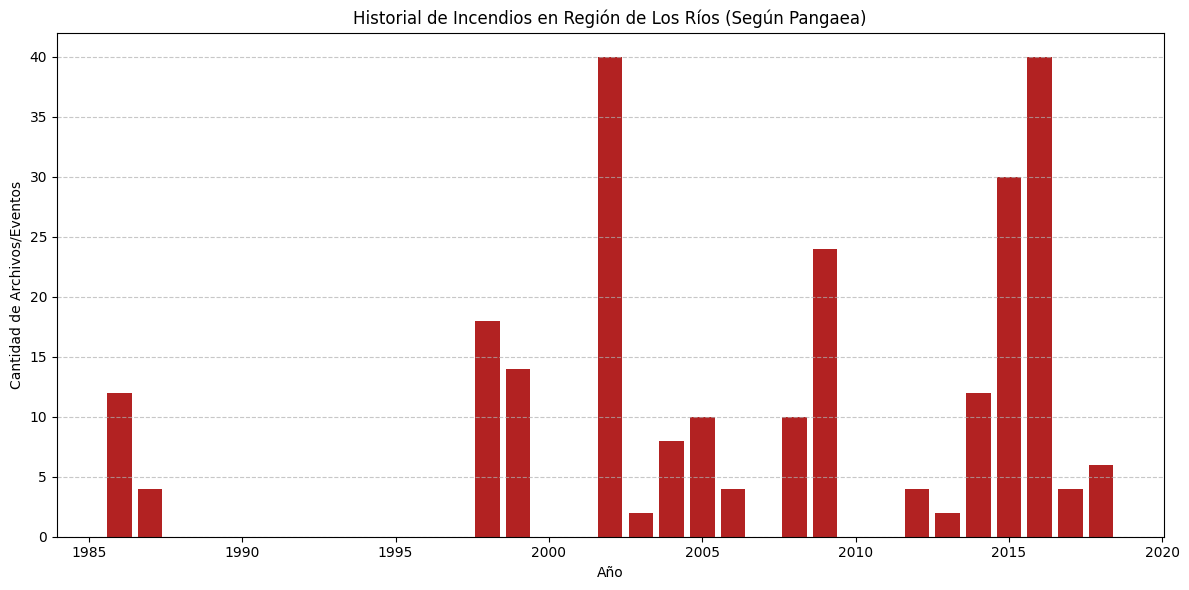

💡 Hallazgo: Este gráfico permite identificar los años más críticos antes de la simulación.


In [8]:
SHAPEFILE_DIR = "../outputs/figures/shapefile"
os.makedirs(SHAPEFILE_DIR, exist_ok=True)

print("--- ANÁLISIS TEMPORAL DE INCENDIOS (PANGAEA) ---")

# Ruta base de Pangaea
base_pangaea = os.path.join(RAW_DIR, "incendios_pangaea/Fire_CL-LR_LosRios")

# Lista para guardar los datos del resumen
stats_incendios = []

# Buscar carpetas que tengan años (ej: ..._2017)
carpetas_anos = sorted(glob.glob(os.path.join(base_pangaea, "*_*")))

for carpeta in carpetas_anos:
    try:
        ano = int(carpeta.split("_")[-1])  # extraer año
        archivos_shp = glob.glob(os.path.join(carpeta, "*.shp"))
        cantidad = len(archivos_shp)
        stats_incendios.append({"Año": ano, "Incendios_Registrados": cantidad})
    except ValueError:
        continue  # saltar carpetas que no terminen en número

# Crear DataFrame para graficar
df_historia = pd.DataFrame(stats_incendios)

if not df_historia.empty:
    # Gráfico de barras: Serie Temporal
    plt.figure(figsize=(12, 6))
    plt.bar(df_historia["Año"], df_historia["Incendios_Registrados"], color='firebrick')
    plt.title("Historial de Incendios en Región de Los Ríos (Según Pangaea)")
    plt.xlabel("Año")
    plt.ylabel("Cantidad de Archivos/Eventos")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Guardar figura en SHAPEFILE_DIR
    plt.savefig(os.path.join(SHAPEFILE_DIR, "incendios_historial.png"), dpi=300)
    plt.show()
    
    print("💡 Hallazgo: Este gráfico permite identificar los años más críticos antes de la simulación.")
else:
    print("⚠️ No se encontraron carpetas de años válidas.")

In [2]:
SHAPEFILE_DIR = "../outputs/figures/shapefile"
os.makedirs(SHAPEFILE_DIR, exist_ok=True)

def load_with_progress(path, color="blue", title="Shapefile", output_name="output.png"):
    """Carga shapefile mostrando progreso y guarda visualización"""
    start_time = time.time()
    with fiona.open(path) as src:
        total = len(src)
        print(f"📂 Archivo: {path}")
        print(f"Total de features: {total}")
        for i, feature in enumerate(src, 1):
            if i % max(1, total // 10) == 0:
                elapsed = time.time() - start_time
                percent = (i / total) * 100
                print(f"   Progreso: {percent:.0f}% ({i}/{total}) en {elapsed:.2f} s")

    gdf = gpd.read_file(path)
    load_time = time.time() - start_time
    print(f"✅ Cargado en {load_time:.2f} segundos. Filas: {len(gdf)}")

    # Visualización
    ax = gdf.plot(figsize=(6,6), color=color, edgecolor="black")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(os.path.join(SHAPEFILE_DIR, output_name), dpi=300)
    plt.close()  # importante para no saturar memoria con muchas figuras

    return gdf


# --- CONAF: Amenaza y Riesgo ---
tasks = []
path_amenaza = os.path.join(RAW_DIR, "conaf_amenaza/shapefiles/14_amenaza_shape.shp")
if os.path.exists(path_amenaza):
    tasks.append(("CONAF - Amenaza", path_amenaza, "orange", "conaf_amenaza_vistazo.png"))

path_riesgo = os.path.join(RAW_DIR, "conaf_riesgo/shapefiles/14_riesgo_shape.shp")
if os.path.exists(path_riesgo):
    tasks.append(("CONAF - Riesgo", path_riesgo, "red", "conaf_riesgo_vistazo.png"))


# --- PANGAEA: Incendios ---
base_pangaea = os.path.join(RAW_DIR, "incendios_pangaea/Fire_CL-LR_LosRios")
carpetas_anos = sorted(glob.glob(os.path.join(base_pangaea, "*_*")))

for carpeta in carpetas_anos[:2]:  # ajusta el rango según lo que quieras procesar
    try:
        ano = int(carpeta.split("_")[-1])
        archivos_shp = glob.glob(os.path.join(carpeta, "*.shp"))
        if archivos_shp:
            tasks.append((f"PANGAEA - Incendio {ano}", archivos_shp[0], "firebrick", f"pangaea_incendio_{ano}_vistazo.png"))
    except ValueError:
        continue


# --- Paralelización ---
results = []
with ThreadPoolExecutor(max_workers=4) as executor:  # ajusta max_workers según tu CPU
    futures = {
        executor.submit(load_with_progress, path, color, title, output_name): title
        for title, path, color, output_name in tasks
    }
    for future in as_completed(futures):
        try:
            gdf_result = future.result()
            results.append(gdf_result)
            print(f"✅ Finalizado: {futures[future]} ({gdf_result.shape})")
        except Exception as e:
            print(f"❌ Error en {futures[future]}: {e}")


📂 Archivo: ../data/raw\conaf_amenaza/shapefiles/14_amenaza_shape.shp
Total de features: 941695
📂 Archivo: ../data/raw\conaf_riesgo/shapefiles/14_riesgo_shape.shp
Total de features: 984468
📂 Archivo: ../data/raw\incendios_pangaea/Fire_CL-LR_LosRios\FireScar_CL-LR_LosRios_1986\FireScar_CL-LR_ID10017_u400_19860108.shp
Total de features: 3
   Progreso: 33% (1/3) en 0.22 s
   Progreso: 67% (2/3) en 0.22 s
   Progreso: 100% (3/3) en 0.22 s
📂 Archivo: ../data/raw\incendios_pangaea/Fire_CL-LR_LosRios\FireScar_CL-LR_LosRios_1987\FireScar_CL-LR_ID13859_u350_19870318.shp
Total de features: 8
   Progreso: 12% (1/8) en 0.25 s
   Progreso: 25% (2/8) en 0.25 s
   Progreso: 38% (3/8) en 0.25 s
   Progreso: 50% (4/8) en 0.25 s
   Progreso: 62% (5/8) en 0.25 s
   Progreso: 75% (6/8) en 0.25 s
   Progreso: 88% (7/8) en 0.25 s
   Progreso: 100% (8/8) en 0.25 s
✅ Cargado en 4.61 segundos. Filas: 3✅ Cargado en 4.68 segundos. Filas: 8

   Progreso: 10% (94169/941695) en 5.25 s
   Progreso: 10% (98446/984468)